<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/nifty_%25_above_50_dma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
nifty50_url = "https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()
# Bank Nifty Stocks
nifty_stocks = tickers

def calculate_percentage_above_moving_average(stock_list,periods,start_date):
    data = yf.download(stock_list, start=start_date)
    data = data['Adj Close']

    # Calculate the moving average using ewm with min_periods set to 50
    ma = data.ewm(span=periods, min_periods=periods).mean()

    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / len(stock_list)) * 100

    return percentage

# Calculate the percentage of stocks above their 200 DMA for each day
percentage_above_dma = calculate_percentage_above_moving_average(nifty_stocks,200,'2018-05-01')
percentage_50_dma=calculate_percentage_above_moving_average(nifty_stocks,20,'2018-05-01')
# Download the Bank Nifty index data
nifty = yf.download('^NSEI', start='2018-05-01')

# Reindex Bank Nifty index data to match percentage_above_dma
aligned_nifty_close = nifty['Adj Close'].reindex(percentage_above_dma.index)




[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
percentage_above_dma_30_ema=percentage_50_dma.rolling(window=30).mean()
percentage_above_dma_10_ema=percentage_50_dma.rolling(window=10).mean()
percemtage_above_dma_200_30=percentage_above_dma.rolling(window=55).mean()
percemtage_above_dma_200_10=percentage_above_dma.rolling(window=15).mean()

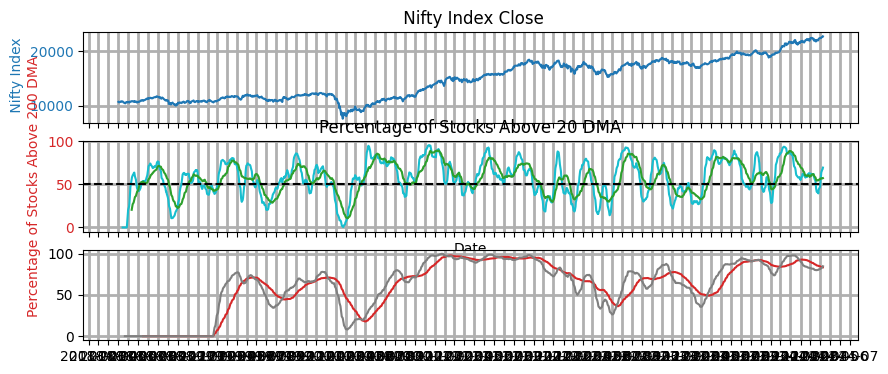

In [4]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel(' Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(' Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
#ax2.plot(percentage_above_dma.index, percentage_above_dma, color='tab:red', label='Percentage Above 200 DMA')
ax2.plot(percentage_50_dma.index, percentage_above_dma_10_ema, color='tab:cyan', label='10-day Moving Average')
ax2.plot(percentage_50_dma.index, percentage_above_dma_30_ema, color='tab:green', label='30-day Moving Average')
ax3.plot(percentage_50_dma.index, percemtage_above_dma_200_30, color='tab:red', label='30-day Moving Average')
ax3.plot(percentage_50_dma.index, percemtage_above_dma_200_10, color='tab:grey', label='10-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 20 DMA')
ax2.axhline(y=50, color='black', linestyle='dashed', label='50% Threshold')
#ax2.legend()

yloc = YearLocator()
mloc = MonthLocator()
ax1.xaxis.set_major_locator(mloc)
ax2.xaxis.set_major_locator(mloc)
ax3.xaxis.set_major_locator(mloc)
#ax[2].xaxis.set_major_locator(mloc)
ax1.grid(linewidth =2)
ax2.grid(linewidth =2)
ax3.grid(linewidth =2)


plt.show()


In [5]:
signal=np.where(percentage_above_dma_10_ema>percentage_above_dma_30_ema,1,-1)
result=percentage_above_dma_10_ema-percentage_above_dma_30_ema

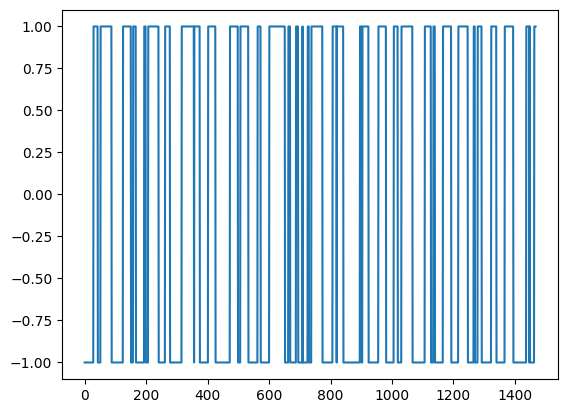

In [6]:
pd.Series(signal).plot();

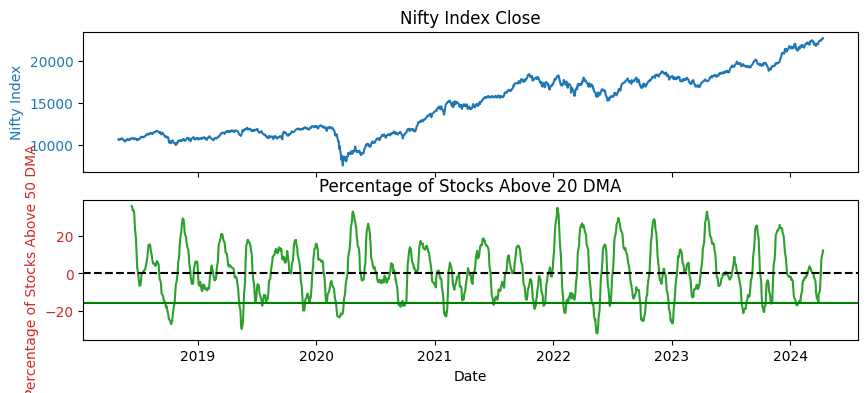

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel('Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 50 DMA', color='tab:red')
ax2.plot(percentage_50_dma.index,result, color='tab:green', label='Percentage Above 50 DMA-(30ema-10ema) smoothing everage')

ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 20 DMA')
ax2.axhline(y=0, color='black', linestyle='dashed', label='50% Threshold')
ax2.axhline(y=-16, color='green', label='buy here or at Divergence')
#ax2.legend(loc='upper left')
plt.show()


In [8]:
#pd.concat(aligned_nifty_close,result)
result_df = pd.concat([aligned_nifty_close, percentage_50_dma], axis=1)
result_df.columns = ['Nifty_Close', 'Pct_Above_DMA10']
result_df.reset_index(inplace=True)

In [9]:
signal.shape

(1468,)

In [10]:
result_df.columns

Index(['Date', 'Nifty_Close', 'Pct_Above_DMA10'], dtype='object')

In [11]:
result_df['Position']=(np.where(signal>0,1,0))
# Calculate returns based on NEXT DAY's Open price
result_df['Returns'] = result_df['Nifty_Close'].pct_change() * result_df['Position']

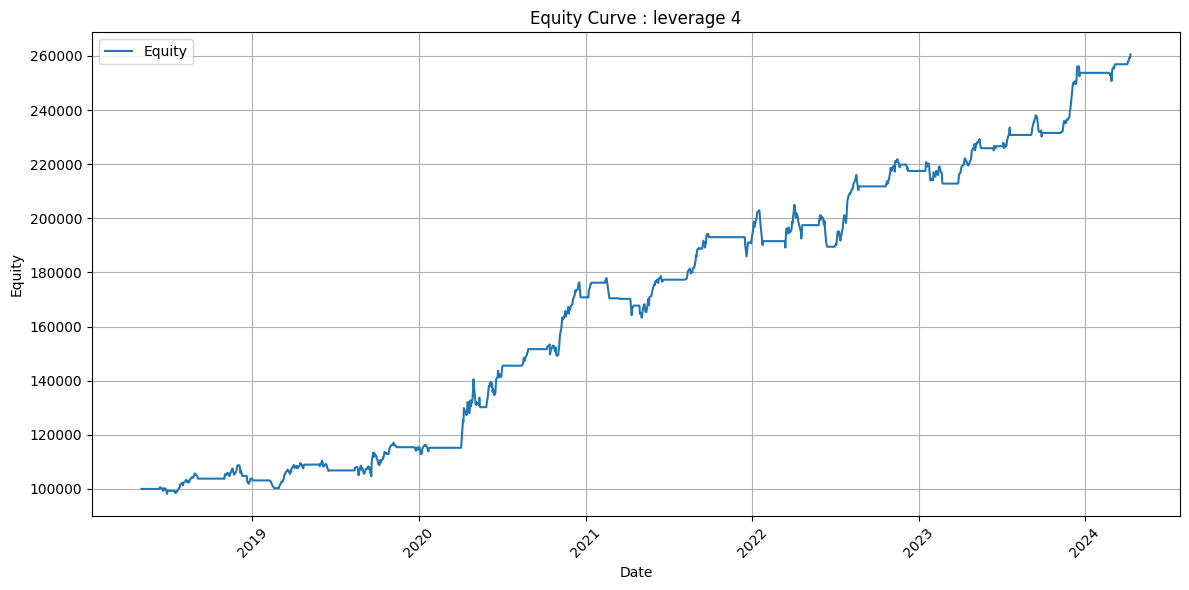

In [12]:
initial_capital = 100000
result_df['Equity'] = initial_capital * (1 + result_df['Returns']).cumprod()
# Plot the Equity Curve
plt.figure(figsize=(12, 6))  # Adjust figure size as desired
plt.plot(result_df.Date, result_df['Equity'], label='Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve : leverage 4')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [13]:
result_df['Position_short']=(np.where(signal<=0,-1,0))
# Calculate returns based on NEXT DAY's Open price
result_df['Return_shrt'] = result_df['Nifty_Close'].pct_change() * result_df['Position_short']

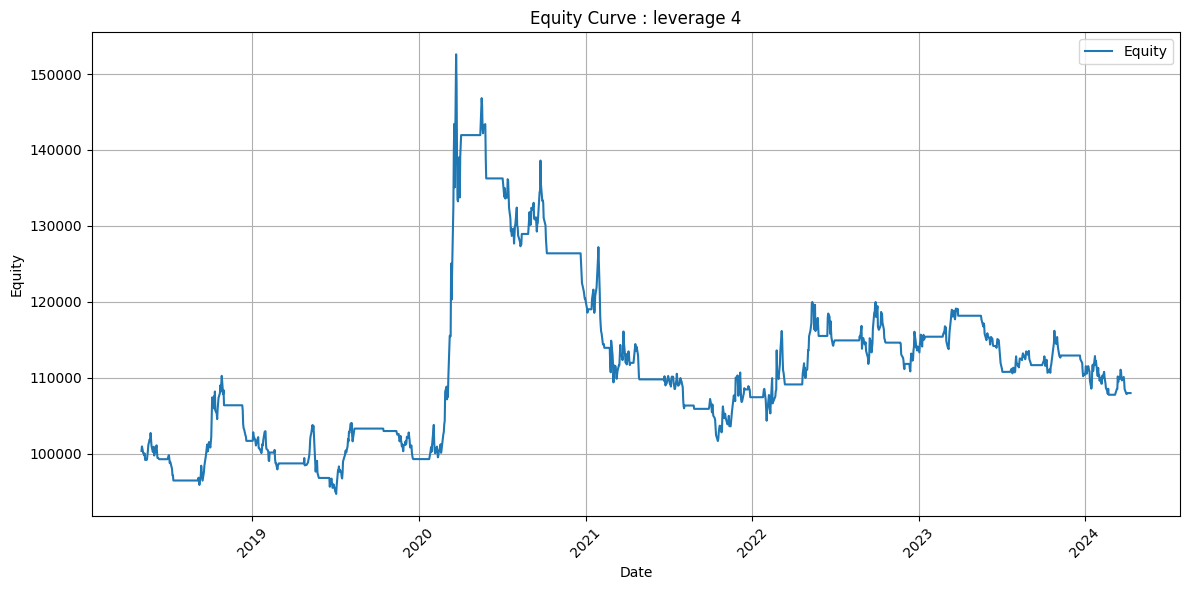

In [14]:
initial_capital = 100000
result_df['Equity_shrt'] = initial_capital * (1 + result_df['Return_shrt']).cumprod()
# Plot the Equity Curve
plt.figure(figsize=(12, 6))  # Adjust figure size as desired
plt.plot(result_df.Date, result_df['Equity_shrt'], label='Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve : leverage 4')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


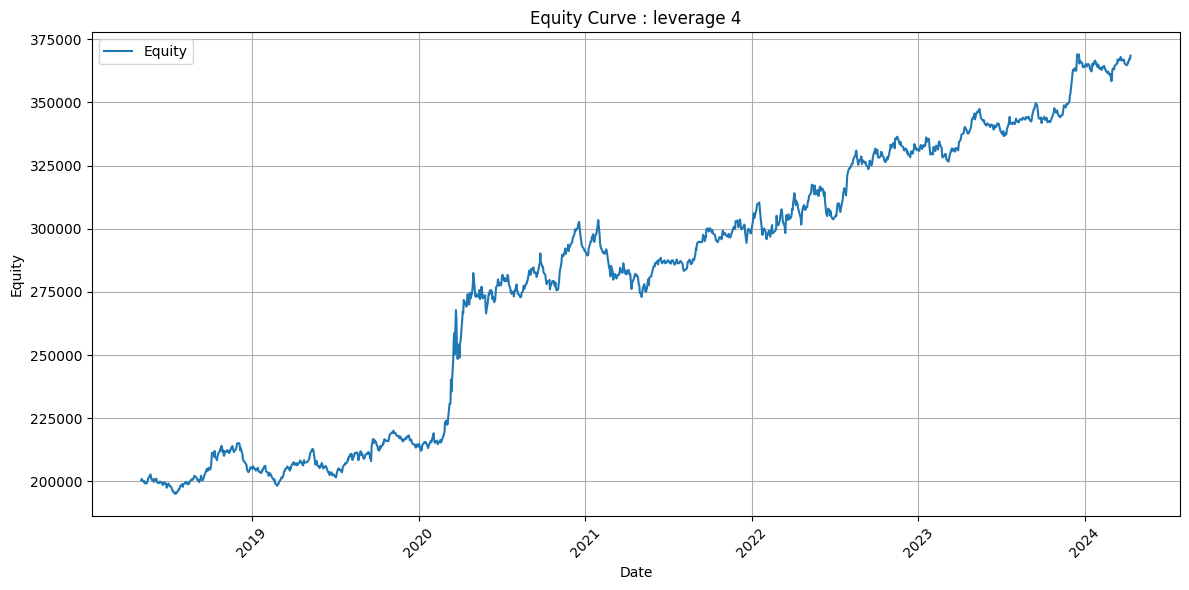

In [15]:

result_df['Equity_total'] = result_df['Equity']+result_df['Equity_shrt']
# Plot the Equity Curve
plt.figure(figsize=(12, 6))  # Adjust figure size as desired
plt.plot(result_df.Date, result_df['Equity_total'], label='Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve : leverage 4')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [16]:
def calculate_metrics(returns_series):
    """Calculates various trade metrics.

    Args:
        returns_series (pandas.Series): A Series of daily returns.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """

    annualized_return = (1 + returns_series).prod() ** (252 / len(returns_series)) - 1
    annualized_std = returns_series.std() * np.sqrt(252)

    sharpe_ratio = annualized_return / annualized_std

    cumulative_returns = (1 + returns_series).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / cumulative_max - 1
    max_drawdown = drawdowns.min()
    calmar_ratio = annualized_return / abs(max_drawdown)

    # Calculate CAGR
    start_value = 1  # Initial investment
    end_value = (1 + returns_series).cumprod().iloc[-1]
    num_years = len(returns_series) / 252  # Assuming 252 trading days
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    metrics = {
        'CAGR': cagr,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_std,
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown
    }

    return metrics

metrics = calculate_metrics(result_df['Returns'])


for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

CAGR: 0.1787
Annualized Return: 0.1787
Annualized Volatility: 0.1060
Sharpe Ratio: 1.6866
Calmar Ratio: 2.1748
Max Drawdown: -0.0822
